# RNA Plots

Bar plots of fibroblast and pluripotency/off-on genes for hets and pseudo-bulk. scRNA similarity with each het sample. See `20201213_scRNA_vs_hetRNA`

Inputs:
1. Heterkaron RNA-seq TPMs
2. Seurat scRNA object
3. Gene sets of interest
4. Cluster config
5. ATAC->RNA transfered labels

In [1]:
library(Seurat)
library(ggplot2)
library(patchwork)
library(scales)
library(matrixStats)

## Load Data
### Heterokayon RNA-seq

In [2]:
tpm_het = read.table("/users/surag/kundajelab/scATAC-reprog/resources/GSE103509/tpm.matrix.txt", sep='\t', header=T)
tpm_het = tpm_het[tpm_het$Gene!="None", ]
tpm_het = tpm_het[!duplicated(tpm_het$Gene),]
rownames(tpm_het) = tpm_het$Gene
tpm_het$Gene = NULL
tpm_het$Ensembl = NULL

tpm_het["GAPDH",]

,GSM2772599_hFb_MRC5_rep1,GSM2772600_hFb_MRC5_rep2,GSM2772601_hFb_MRC5_rep3,GSM2772602_Co.cult_rep1,GSM2772603_Co.cult_rep2,GSM2772604_co.cult_rep3,GSM2772605_30min_rep1,GSM2772606_30min_rep2,GSM2772607_30min_rep3,GSM2772608_2h_rep1,⋯,GSM2772610_2h_rep3,GSM2772611_6h_rep1,GSM2772612_6h_rep2,GSM2772613_6h_rep3,GSM2772614_12h_rep1,GSM2772615_12h_rep2,GSM2772616_12h_rep3,GSM2772617_24h_rep1,GSM2772618_24h_rep2,GSM2772619_24h_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GAPDH,4909.54,4797.98,3419.12,5400.76,5767.35,4277.84,5474.26,5490.53,4537.26,4826.46,⋯,4173.66,5217.96,5214.19,4473.25,5868.08,5776.31,4581.95,6361.69,5933.19,5486.53


In [3]:
# shorten names
colnames(tpm_het) = paste(paste(lapply(strsplit(colnames(tpm_het), "_"), "[[", 2), 
                                lapply(strsplit(colnames(tpm_het), "_"), "tail", 1),
                          sep='_'))

In [4]:
# making case same as others
colnames(tpm_het)[6] = 'Co.cult_rep3'

In [5]:
head(tpm_het)

,hFb_rep1,hFb_rep2,hFb_rep3,Co.cult_rep1,Co.cult_rep2,Co.cult_rep3,30min_rep1,30min_rep2,30min_rep3,2h_rep1,⋯,2h_rep3,6h_rep1,6h_rep2,6h_rep3,12h_rep1,12h_rep2,12h_rep3,24h_rep1,24h_rep2,24h_rep3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC008147.4,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.31002,0.0000
GSC2,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
RNA5SP510,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
CHRM3-AS1,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
BPY2DP,0.0000,0.0000,0.0000,0.00,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,⋯,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.00000,0.0000
RTL8A,76.4726,82.9742,68.0836,88.86,94.7277,61.5797,84.5301,84.8045,54.6292,82.6592,⋯,65.4956,58.4438,63.2025,67.486,36.874,56.7114,32.8462,31.9511,41.43000,27.5791


In [6]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [7]:
dim(tpm_het)

[1] 56520    21

In [8]:
# average reps (3 reps per time point)
tpm_het_avg = (as.matrix(tpm_het) %*% create_sum_matrix(21,3))/3
colnames(tpm_het_avg) = unlist(unique(lapply(strsplit(colnames(tpm_het), "_"), "[[", 1)))

# filter low expression
# tpm_het_avg = tpm_het_avg[rowMaxs(tpm_het_avg)>1, ]

dim(tpm_het_avg)
head(tpm_het_avg)

[1] 56520     7

,hFb,Co.cult,30min,2h,6h,12h,24h
AC008147.4,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.10334
GSC2,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
RNA5SP510,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
CHRM3-AS1,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
BPY2DP,0.00000,0.00000,0.0000,0.0000,0.0000,0.00000,0.00000
RTL8A,75.84347,81.72247,74.6546,70.7138,63.0441,42.14387,33.65340


### scRNA Seurat object

In [9]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")

### Gene Sets

In [11]:
gene_sets= list()

for (i in seq(10)) {
    gene_sets[[i]] = as.character(unlist(read.table(sprintf("../../analysis/20200828_RNA_Seurat/gene_sets/20201012_tmp_gridmap_znorm_n10/idx%d.txt", i))$V1))
}

### Fibroblast Genes

In [12]:
fib_genes = as.character(unlist(read.table("./fibroblast.genes.list")$V1))
length(fib_genes)

[1] 88

In [13]:
fib_genes

[1] "AADAC"    "ACTA2"    "AFP"      "APOA1"    "APOC2"    "APOH"    
 [7] "ASGR2"    "ASS1"     "C3"       "CAV1"     "CAV2"     "CCL2"    
[13] "CD55"     "CDH5"     "COL1A1"   "COL4A2"   "COL6A1"   "COL6A3"  
[19] "CXCL13"   "CYB5A"    "EDNRA"    "EGFL6"    "EHD2"     "ELN"     
[25] "EPAS1"    "FABP1"    "FBLN1"    "FGFR2"    "FGG"      "FN1"     
[31] "GC"       "GPR116"   "GRP"      "HGD"      "HIF1A"    "HIF3A"   
[37] "HPGD"     "ICAM1"    "IL6"      "IL8"      "KRT7"     "LAMA3"   
[43] "LAMC1"    "LOXL1"    "LPHN2"    "LTF"      "LUM"      "LURAP1L" 
[49] "LYVE1"    "MEOX2"    "MEST"     "MFAP4"    "MMP19"    "MMP2"    
[55] "MT2A"     "MUC1"     "MYH11"    "NAMPT"    "NAP1L1"   "NFKBIZ"  
[61] "NID1"     "PCOLCE"   "PFN1"     "PPIB"     "PTBP1"    "PTX3"    
[67] "PXDN"     "RARRES1"  "RBPMS"    "S100P"    "SERPINE1" "SLC25A37"
[73] "SLC39A14" "SLC52A2"  "SMAD6"    "SOD2"     "TBX3"     "TCF21"   
[79] "THBS1"    "THY1"     "TIMP3"    "TM4SF1"   "TM4SF4"   "TNC"     
[85] "TNFAIP3"  "TNFAIP6"  "VAMP8"    "WSB1"

### Cluster Config

In [14]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster,colour,description,new_cluster
<int>,<fct>,<fct>,<int>
1,#A6D854,Pre-iPSC,14
2,#F0A118,Intermediate,12
3,#E85F6D,Fibroblast-like,3
4,#006658,Neural-like,8
5,#B03743,Fibroblast,1
6,#CF175A,Fibroblast-like,4
7,#78A824,Pre-iPSC,13
8,#F4D5CD,Intermediate,11
9,#D4B81C,Intermediate,9


### ATAC-RNA Label Transfer

In [16]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,5,1
AAACCCAAGTGCCAGA-1,D0,5,1
AAACCCACACCATTCC-1,D0,5,1
AAACCCACACGCGTCA-1,D0,5,1
AAACCCAGTCCATAGT-1,D0,5,1
AAACCCAGTTATTCTC-1,D0,5,1


## Process

In [17]:
# RNA is normalized to 10,000 reads
colSums(as.matrix(exp(rna[["RNA"]][,1:10])-1))

AAACCCAAGAGTGACC-1 AAACCCAAGTGCCAGA-1 AAACCCACACCATTCC-1 AAACCCACACGCGTCA-1 
             10000              10000              10000              10000 
AAACCCAGTCCATAGT-1 AAACCCAGTTATTCTC-1 AAACCCAGTTGTAGCT-1 AAACCCATCAGACATC-1 
             10000              10000              10000              10000 
AAACCCATCCGTAGGC-1 AAACCCATCGTTAGAC-1 
             10000              10000

In [18]:
common_genes = intersect(rownames(rna), rownames(tpm_het_avg))
length(common_genes)

[1] 25860

In [19]:
scrna_cts = rna@assays$RNA@counts[common_genes, ]
scrna_tp10k = 1e4*Matrix::t(Matrix::t(scrna_cts)/Matrix::colSums(scrna_cts))
scrna_tp10k_log = log(1+scrna_tp10k)

In [20]:
het_tp10k = 1e4*t(t(tpm_het_avg[common_genes, ])/colSums(tpm_het_avg[common_genes, ]))
het_tp10k_log = log(1+het_tp10k)

In [59]:
head(het_tp10k)

,hFb,Co.cult,30min,2h,6h,12h,24h
AL627309.1,0.006051002,0.000000000,0.0000000000,0.002857965,0.003638728,0.000000000,0.002623503
AL627309.5,0.010474881,0.025562184,0.0162869156,0.006371727,0.013282224,0.005233389,0.016607464
LINC01409,0.018169656,0.002110975,0.0496852945,0.026372380,0.026597743,0.005799427,0.008466497
FAM87B,0.001263266,0.000000000,0.0006391046,0.003097496,0.001114275,0.001555871,0.000000000
LINC01128,0.087600156,0.072861198,0.0809807788,0.158614629,0.151324089,0.118675114,0.097913901
LINC00115,0.009291280,0.010539897,0.0091094793,0.008254732,0.003786680,0.012356155,0.043246854


In [21]:
het_with_rep_tp10k = 1e4*t(t(tpm_het[common_genes,])/colSums(tpm_het[common_genes,]))

In [47]:
# pseudo-bulk RNA
agg_matrix = Matrix::sparseMatrix(i=seq(1,nrow(atac.rna.label)),
                                  j=atac.rna.label$atac_new_cluster,
                                  x=1L,
                                  dims=c(nrow(atac.rna.label), 
                                         length(table(atac.rna.label$atac_new_cluster))))

In [48]:
# modify agg matrix cluster 1 to only include D0 cells (there is some contamination)
table(rna$sample[agg_matrix[, 1]>0])

agg_matrix[, 1][rna$sample != "D0"] = 0

table(rna$sample[agg_matrix[, 1]>0])


   D0   D10   D12   D14    D2    D4    D6    D8 
10312   416    18    12  1126   564    92    83 


   D0 
10312 

In [49]:
scrna_bulk_cts = as.matrix(scrna_cts %*% agg_matrix)
colnames(scrna_bulk_cts) = paste("cluster", seq(ncol(scrna_bulk_cts)), sep='')
rownames(scrna_bulk_cts) = rownames(scrna_cts)

head(scrna_bulk_cts)
dim(scrna_bulk_cts)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14
AL627309.1,15,0,3,3,1,2,0,0,3,2,4,25,20,23
AL627309.5,56,1,27,19,23,26,1,4,22,35,35,80,54,136
LINC01409,223,4,95,95,72,75,7,23,118,105,231,451,193,344
FAM87B,6,1,8,16,4,14,1,4,12,6,23,14,1,6
LINC01128,705,41,470,651,219,493,43,189,557,292,955,1249,485,720
LINC00115,72,1,42,59,31,35,3,5,54,48,74,78,43,104


[1] 25860    14

In [50]:
scrna_bulk_tp10k = 1e4*t(t(scrna_bulk_cts)/colSums(scrna_bulk_cts))

In [53]:
100*scrna_bulk_tp10k["AICDA", ]

cluster1   cluster2   cluster3   cluster4   cluster5   cluster6   cluster7 
0.00000000 0.00000000 0.00000000 0.00000000 0.03548541 0.00000000 0.00000000 
  cluster8   cluster9  cluster10  cluster11  cluster12  cluster13  cluster14 
0.07759118 0.00000000 0.11788350 0.05913189 0.32806998 0.24482668 0.35822484

## Count Based Analysis

### Fibroblast/ON-OFF Genes

In [65]:
MIN_EXPR_IN_FIB_TPM = 10

In [74]:
# pick from list of fib genes
# fib_genes_subset = fib_genes[fib_genes %in% common_genes]

# or pick genes that turn off
fib_genes_subset = c(gene_sets[[3]], gene_sets[[9]])
fib_genes_subset = fib_genes_subset[fib_genes_subset %in% common_genes]
fib_genes_subset = fib_genes_subset[fib_genes_subset %in% VariableFeatures(rna)]

# more than THRESH TPM in fibroblasts
fib_genes_subset = fib_genes_subset[scrna_bulk_tp10k[fib_genes_subset, "cluster1"] > MIN_EXPR_IN_FIB_TPM/100]

# more than THRESH*100 TPM in het fibroblasts?
fib_genes_subset = fib_genes_subset[het_tp10k[fib_genes_subset, "Co.cult"] > MIN_EXPR_IN_FIB_TPM/100]

length(fib_genes_subset)

colSums(het_tp10k[fib_genes_subset, ]>0)
colSums(het_tp10k[fib_genes_subset, ]>0.001)
colSums(het_tp10k[fib_genes_subset, ]>0.005)
colSums(het_tp10k[fib_genes_subset, ]>0.01)
colSums(het_tp10k[fib_genes_subset, ]>0.1)

colSums(het_with_rep_tp10k[fib_genes_subset,] > MIN_EXPR_IN_FIB_TPM/100)
colSums(scrna_bulk_tp10k[fib_genes_subset,] > MIN_EXPR_IN_FIB_TPM/100)

[1] 208

hFb Co.cult   30min      2h      6h     12h     24h 
    208     208     208     208     208     208     208

hFb Co.cult   30min      2h      6h     12h     24h 
    208     208     208     208     208     208     208

hFb Co.cult   30min      2h      6h     12h     24h 
    208     208     208     208     208     208     208

hFb Co.cult   30min      2h      6h     12h     24h 
    208     208     208     208     208     208     207

hFb Co.cult   30min      2h      6h     12h     24h 
    202     208     205     202     194     192     191

hFb_rep1     hFb_rep2     hFb_rep3 Co.cult_rep1 Co.cult_rep2 Co.cult_rep3 
         200          198          199          202          204          201 
  30min_rep1   30min_rep2   30min_rep3      2h_rep1      2h_rep2      2h_rep3 
         205          207          200          200          202          197 
     6h_rep1      6h_rep2      6h_rep3     12h_rep1     12h_rep2     12h_rep3 
         193          189          193          184          185          192 
    24h_rep1     24h_rep2     24h_rep3 
         189          189          182

cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  cluster7  cluster8 
      208       189       196       193       190       188       174       143 
 cluster9 cluster10 cluster11 cluster12 cluster13 cluster14 
      170       159       147       132       101        78

In [75]:
colSums(het_tp10k[fib_genes_subset, ] > het_tp10k[fib_genes_subset, "Co.cult"]/2)

hFb Co.cult   30min      2h      6h     12h     24h 
    193     208     207     197     172     144     137

In [76]:
colSums(scrna_bulk_tp10k[fib_genes_subset,] > scrna_bulk_tp10k[fib_genes_subset, "cluster1"]/2)

cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  cluster7  cluster8 
      208        92       132       120       124        81        67        44 
 cluster9 cluster10 cluster11 cluster12 cluster13 cluster14 
       56        41        41        29        10         7

In [421]:
dim(rna[["RNA"]])

[1] 27632 59369

In [400]:
CLUSTERS = c(1,7,11,12,13,14)
select_clusters = paste("cluster", CLUSTERS, sep='')

to_plot = 100*colSums(scrna_bulk_tp10k[fib_genes_subset,select_clusters] > scrna_bulk_tp10k[fib_genes_subset, "cluster1"]/2)/length(fib_genes_subset)
to_plot = data.frame(x=names(to_plot),
                    y=to_plot)
to_plot$x = factor(to_plot$x, levels=to_plot$x)

on_off_sc <- ggplot(to_plot) + 
geom_bar(aes(x=x,y=y), stat="identity", fill="tomato") +
theme_classic(base_size = 20) +
theme(axis.title.x=element_blank(), #element_text(margin = margin(t=15)),
     axis.text.x=element_blank()) + #element_text(angle=45,  hjust=1)) + 
xlab("scRNA Cell State") +
ylim(c(0,100))+
ylab("% Genes")

In [401]:
select_times = c("Co.cult", "6h", "12h", "24h")

to_plot = 100*colSums(het_with_rep_tp10k[fib_genes_subset,] > het_tp10k[fib_genes_subset, "Co.cult"]/2)/length(fib_genes_subset)
to_plot = data.frame(x=names(to_plot),
                    y=to_plot)
to_plot$x = lapply(strsplit(as.character(to_plot$x), "_"), "[[", 1)
to_plot = to_plot[to_plot$x %in% select_times, ]
to_plot$x = factor(to_plot$x, levels=unique(to_plot$x))
mean_df = aggregate(to_plot[,c("y")], by=list(to_plot$x), mean)

on_off_het <- ggplot() + 
geom_bar(data = mean_df, aes(x=Group.1, y=x), stat="identity", fill="red", alpha=0.5) + 
geom_jitter(data= to_plot, aes(x=x,y=y), width = 0.25, height = 0, size=3) +
theme_classic(base_size = 20) +
theme(axis.title.y=element_blank(),
      axis.text.y=element_blank(),
#       axis.line.y=element_blank(),
#       axis.ticks.y=element_blank(),
      axis.title.x=element_text(margin = margin(t=10))) +
xlab("Heterokaryon Time Point") +
ylab("% Genes") +
ylim(c(0,100))

In [722]:
cluster_config_selected

,cluster,colour,description,new_cluster
,<int>,<fct>,<fct>,<int>
1,1,#A6D854,Pre-iPSC,14
2,2,#F0A118,Intermediate,12
5,5,#B03743,Fibroblast,1
7,7,#78A824,Pre-iPSC,13
8,8,#F4D5CD,Intermediate,11
14,14,#F0520A,Early intermediate,7


In [727]:
cluster_config_selected = cluster_config[cluster_config$new_cluster %in% CLUSTERS,]

cluster_colourbar <- ggplot(cluster_config_selected, 
                            aes(x=as.factor(new_cluster), 
                            y=1, 
                            fill = as.factor(new_cluster), 
                            label=as.factor(new_cluster))) +
  geom_bar(stat="identity") +
  xlab("scRNA Cell State") +
  theme_void() +
  scale_fill_manual(values = as.character(cluster_config_selected$colour[order(cluster_config_selected$new_cluster)])) +
  theme(legend.position = 'none',
        axis.text.x = element_text(size=16, margin=margin(t=-16)),
        axis.title.x = element_text(size=20, margin=margin(t=10))) # adjust this to match heights

In [728]:
on_off_sc_w_cb = wrap_plots(plot_spacer(),
                            on_off_sc,
                            cluster_colourbar,
                            plot_spacer(),
                            heights=c(0,4.7,.3,0))

In [729]:
on_off_title = ggplot() + 
               ggtitle(sprintf("Fibroblast Genes (n=%d) Expressed > 0.5 x Basal Level", length(fib_genes_subset))) +
               theme_void() + 
               theme(plot.title=element_text(hjust=0.5, size=22),)

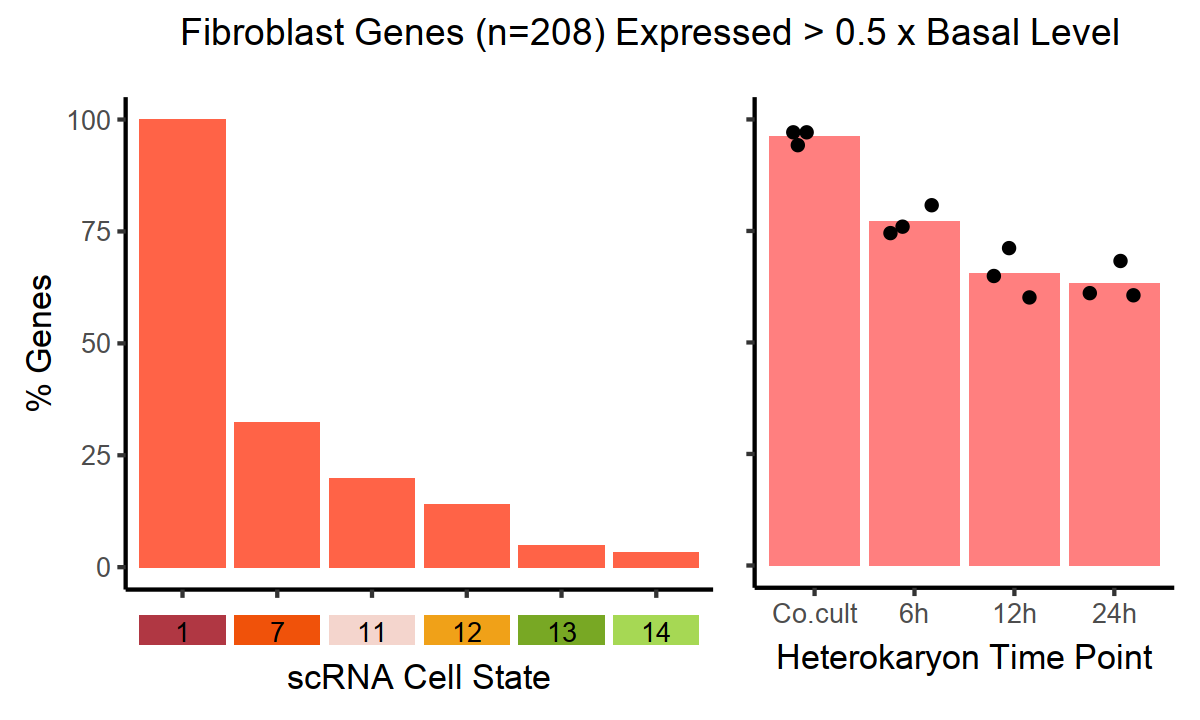

In [730]:
options(repr.plot.width = 10, repr.plot.height = 6)

on_off_plots = wrap_plots(on_off_sc_w_cb, 
                             wrap_plots(plot_spacer(),
                                        on_off_het,
                                        plot_spacer(), 
                                        heights=c(0,1,0)),
                             widths=c(7,5))
on_off_combined=wrap_plots(on_off_title,
                          on_off_plots,
                          heights=c(0.1,5.9))

on_off_combined

### OFF-ON Genes

In [731]:
THRESH = 0.5

# off_on_genes = c(gene_sets[[2]], gene_sets[[7]])
# off_on_genes = c(gene_sets[[2]], gene_sets[[7]], gene_sets[[10]])
# off_on_genes = c(gene_sets[[2]], gene_sets[[10]])
# off_on_genes = c(gene_sets[[2]])
off_on_genes = c(gene_sets[[2]])
# off_on_genes = c(gene_sets[[10]])

off_on_genes = off_on_genes[off_on_genes %in% common_genes]
# off_on_genes = off_on_genes[off_on_genes %in% VariableFeatures(rna)]

# less than THRESH TPM in fibroblasts
off_on_genes = off_on_genes[scrna_bulk_tp10k[off_on_genes, "cluster1"] <= THRESH/100]

# less than THRESH TPM in het fibroblasts?
off_on_genes = off_on_genes[het_tp10k[off_on_genes, "Co.cult"] <= THRESH/100]

# # more than THRESH*100 TPM in C14 (D14 pre-iPSC)
# off_on_genes = off_on_genes[scrna_bulk_tp10k[off_on_genes, "cluster14"] > THRESH]

length(off_on_genes)

colSums(het_tp10k[off_on_genes, ]>0)
colSums(het_tp10k[off_on_genes, ]>0.001)
colSums(het_tp10k[off_on_genes, ]>0.005)
colSums(het_tp10k[off_on_genes, ]>0.01)
colSums(het_tp10k[off_on_genes, ]>0.1)

colSums(het_with_rep_tp10k[off_on_genes,] > THRESH/100)
colSums(scrna_bulk_tp10k[off_on_genes,] > THRESH/100)

[1] 202

hFb Co.cult   30min      2h      6h     12h     24h 
     60      21      42      41      56      77     127

hFb Co.cult   30min      2h      6h     12h     24h 
     37      13      30      33      42      67     111

hFb Co.cult   30min      2h      6h     12h     24h 
      8       0      10      14      22      37      69

hFb Co.cult   30min      2h      6h     12h     24h 
      3       0       3       8       8      16      47

hFb Co.cult   30min      2h      6h     12h     24h 
      0       0       0       0       0       0       1

hFb_rep1     hFb_rep2     hFb_rep3 Co.cult_rep1 Co.cult_rep2 Co.cult_rep3 
           8            8           14            2            5            4 
  30min_rep1   30min_rep2   30min_rep3      2h_rep1      2h_rep2      2h_rep3 
          12            9           10           16           13           14 
     6h_rep1      6h_rep2      6h_rep3     12h_rep1     12h_rep2     12h_rep3 
          16           17           20           33           36           18 
    24h_rep1     24h_rep2     24h_rep3 
          70           77           49

cluster1  cluster2  cluster3  cluster4  cluster5  cluster6  cluster7  cluster8 
        0        14         7         4        54        18         9         6 
 cluster9 cluster10 cluster11 cluster12 cluster13 cluster14 
       19        80         9        86       147       199

In [732]:
off_on_genes[het_tp10k[off_on_genes, "24h"] > THRESH/100]

[1] "POU3F1"     "FOXD3"      "BRDT"       "FMO5"       "LINC02805" 
 [6] "MIR205HG"   "LEFTY1"     "GREB1"      "AC106875.1" "ALPG"      
[11] "EFHD1"      "FRG2C"      "BEND4"      "CNGA1"      "GSX2"      
[16] "SFRP2"      "NKX2-5"     "DPPA5"      "ICA1"       "CLDN3"     
[21] "NCF1"       "NPTX2"      "LINC02577"  "LRATD2"     "RLN2"      
[26] "FAM189A2"   "NODAL"      "ANKRD1"     "FGFR2"      "ART5"      
[31] "AC087521.2" "LARGE2"     "TRIM64B"    "SCNN1A"     "FAM90A1"   
[36] "AICDA"      "AC092490.1" "IL23A"      "LINC01405"  "TESC"      
[41] "ZIC2"       "TCL1B"      "TUNAR"      "IGDCC3"     "CLDN6"     
[46] "PRSS8"      "ITGAM"      "CDH8"       "NRN1L"      "CDH3"      
[51] "CDH1"       "PPP1R1B"    "GRB7"       "CSH1"       "TJP3"      
[56] "NRTN"       "EPHX3"      "SYNE4"      "MAP4K1"     "CNTD2"     
[61] "AVP"        "WFDC2"      "MMP9"       "CTCFL"      "TBX1"      
[66] "FAM83F"     "ITM2A"      "PLP1"       "TKTL1"

In [733]:
100*het_tp10k["ZIC2", ]

hFb    Co.cult      30min         2h         6h        12h        24h 
0.00000000 0.25079699 0.27684060 0.25174129 0.10028482 0.07655851 1.08684394

In [734]:
# 100*scrna_bulk_tp10k["ZIC2", ]

In [735]:
CLUSTERS = c(1,7,11,12,13,14)
select_clusters = paste("cluster", CLUSTERS, sep='')

to_plot = 100*colSums(scrna_bulk_tp10k[off_on_genes,select_clusters] > THRESH/100)/length(off_on_genes)
to_plot = data.frame(x=names(to_plot),
                    y=to_plot)
to_plot$x = factor(to_plot$x, levels=to_plot$x)

off_on_sc <- ggplot(to_plot) + 
geom_bar(aes(x=x,y=y), stat="identity", fill="royalblue3") +
theme_classic(base_size = 20) +
theme(axis.title.x=element_blank(), #element_text(margin = margin(t=15)),
     axis.text.x=element_blank()) + #element_text(angle=45,  hjust=1)) + 
xlab("scRNA Cell State") +
ylim(c(0,100))+
ylab("% Genes")

In [736]:
select_times = c("Co.cult", "6h", "12h", "24h")

to_plot = 100*colSums(het_with_rep_tp10k[off_on_genes,] > THRESH/100)/length(off_on_genes)
to_plot = data.frame(x=names(to_plot),
                    y=to_plot)
to_plot$x = lapply(strsplit(as.character(to_plot$x), "_"), "[[", 1)
to_plot = to_plot[to_plot$x %in% select_times, ]
to_plot$x = factor(to_plot$x, levels=unique(to_plot$x))
mean_df = aggregate(to_plot[,c("y")], by=list(to_plot$x), mean)

off_on_het <- ggplot() + 
geom_bar(data = mean_df, aes(x=Group.1, y=x), stat="identity", fill="royalblue", alpha=0.75) + 
geom_jitter(data= to_plot, aes(x=x,y=y), width = 0.25, height = 0, size=3) +
theme_classic(base_size = 20) +
theme(axis.title.y=element_blank(),
      axis.text.y=element_blank(),
#       axis.line.y=element_blank(),
#       axis.ticks.y=element_blank(),
      axis.title.x=element_text(margin = margin(t=10))) +
xlab("Heterokaryon Time Point") +
ylab("% Genes") +
ylim(c(0,100))

In [737]:
off_on_sc_w_cb = wrap_plots(plot_spacer(),
                            off_on_sc,
                            cluster_colourbar,
                            plot_spacer(),
                            heights=c(0,4.7,.3,0))

In [738]:
off_on_title = ggplot() + 
               ggtitle(sprintf("Late ON Genes (n=%d) Expressed > 0.5 TPM", length(off_on_genes)))+
               theme_void() + 
               theme(plot.title=element_text(hjust=0.5, size=22),)

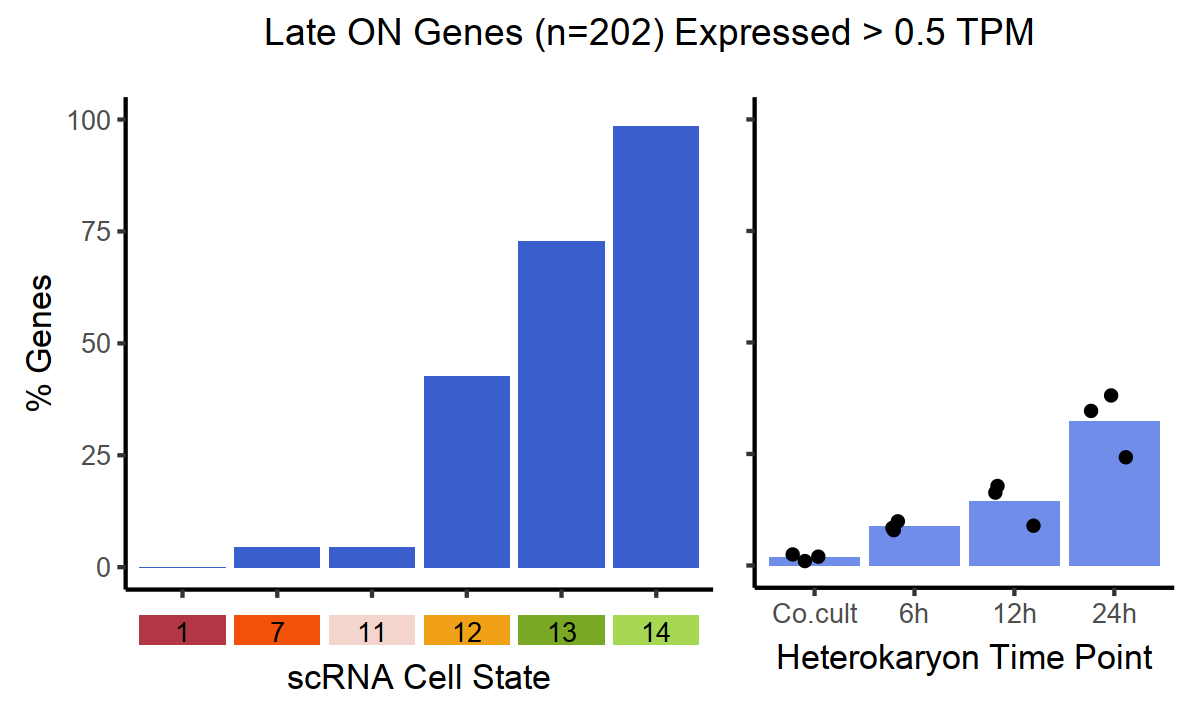

In [739]:
options(repr.plot.width = 10, repr.plot.height = 6)

off_on_plots = wrap_plots(off_on_sc_w_cb, 
                             wrap_plots(plot_spacer(),
                                        off_on_het,
                                        plot_spacer(), 
                                        heights=c(0,1,0)),
                             widths=c(7,5))
off_on_combined=wrap_plots(off_on_title,
                          off_on_plots,
                          heights=c(0.1,5.9))

off_on_combined

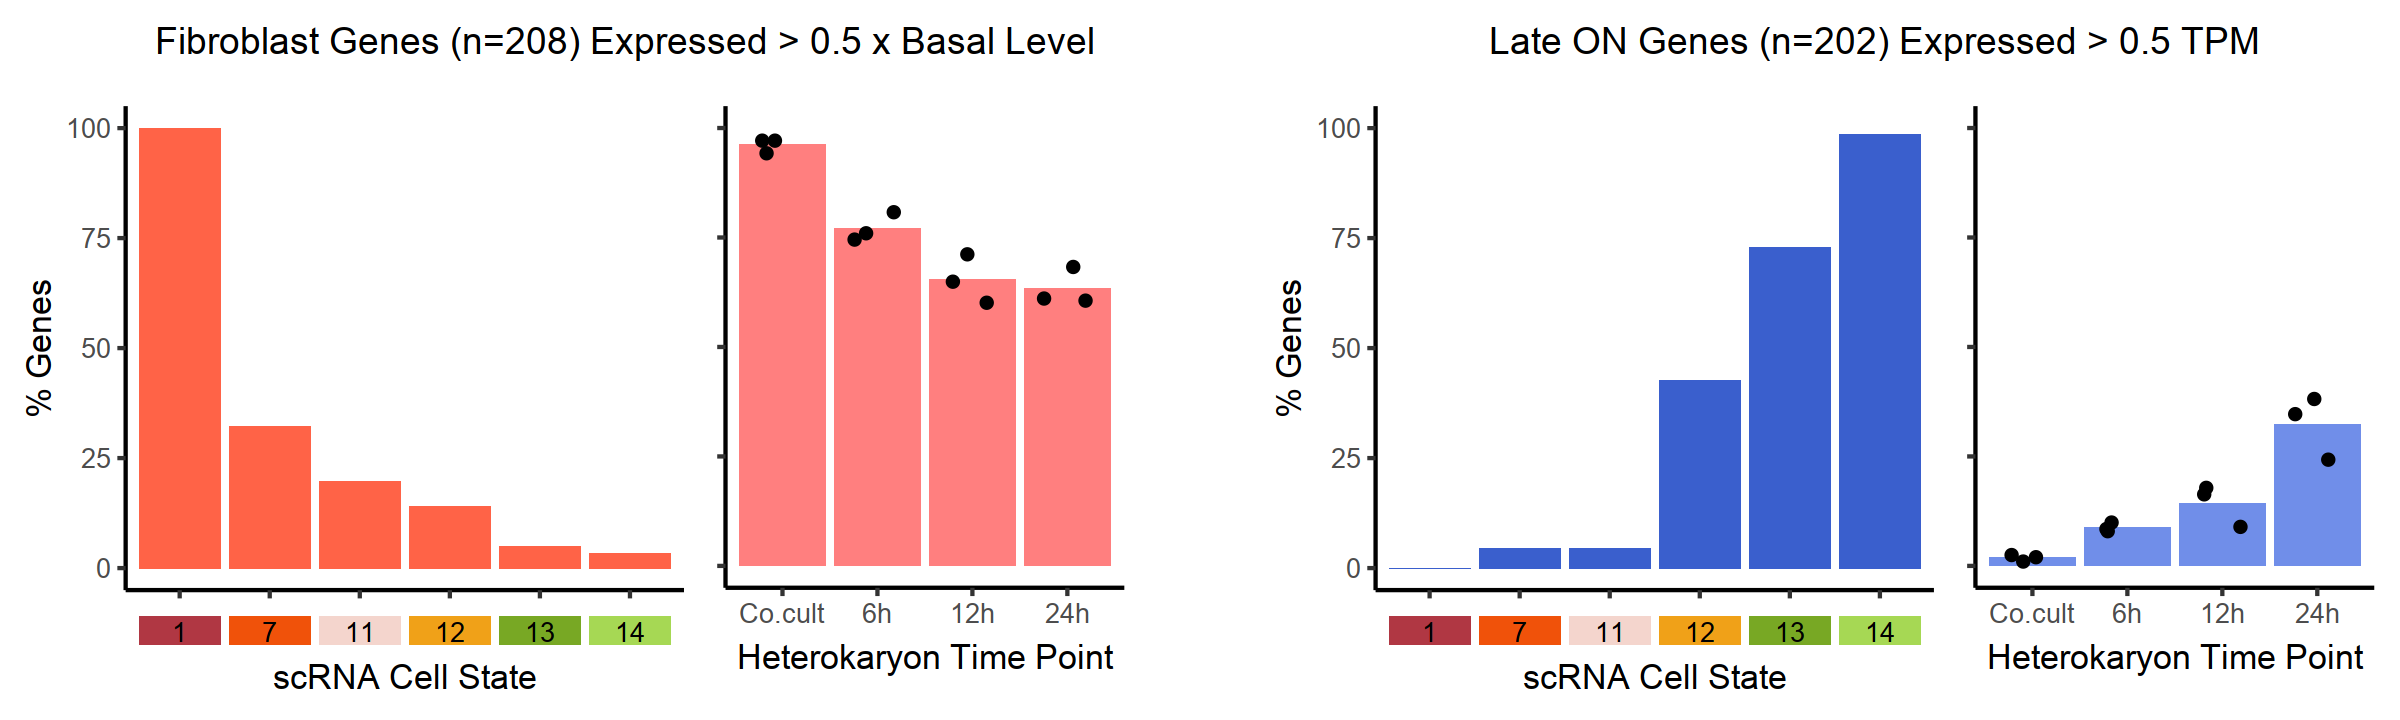

In [740]:
options(repr.plot.width = 20, repr.plot.height = 6)

bar_plots_combined <- wrap_plots(on_off_combined,
                                 plot_spacer(),
                                 off_on_combined,
                                 widths=c(1,0.1,1))

bar_plots_combined

In [741]:
saveRDS(bar_plots_combined, file=sprintf("./subfigs/%s_rna_bar_plots.rds",
                                format(Sys.Date(), "%Y%m%d")))

## Single-cell Resolution Similarity

In [529]:
# genes_of_interest = c(gene_sets[[2]], gene_sets[[7]])
# genes_of_interest = c(gene_sets[[4]])
genes_of_interest = common_genes

genes_of_interest = genes_of_interest[genes_of_interest %in% common_genes]

# only in top 2k variable genes?
genes_of_interest = genes_of_interest[genes_of_interest %in% VariableFeatures(rna)]

# exclude exogenous genes
genes_of_interest = genes_of_interest[!genes_of_interest %in% c("POU5F1", "SOX2", "KLF4", "MYC")]

length(genes_of_interest)

[1] 1927

In [709]:
plot_sim_umap <- function(df, title=T, ylabel=F, legend=F) {
    lims = c(quantile(df$sim, 0.05),
             quantile(df$sim, 0.99))
    p <- ggplot(df) +
    geom_point(size=.5, stroke = 0, alpha=1, aes(x=umap1 , y=umap2, col=sim)) +
    xlab("UMAP 1") + ylab("UMAP 2") +
    scale_color_viridis_c(limits=lims, 
                          oob=squish, 
                          option = "A",
                          breaks=lims,
                          labels=c("Min","Max"),
                         name="Similarity") +
    theme_classic() +
    theme(legend.position = "none",
         axis.ticks = element_blank(),
         axis.text =element_blank(),
         axis.line=element_blank(),
         axis.title.x=element_blank(),
         panel.border = element_rect(colour = "white", fill=NA, size=0.5)) +
    coord_fixed()
    
    if (title==T) {
        p <- p + ggtitle(i) + theme(plot.title = element_text(size=22, 
                                                              hjust = 0.5))
    }
    
    if (ylabel!=F) {
        p <- p + ylab(ylabel) + theme(axis.title.y=element_text(size=16)) 
    }
    else {
        p <- p + theme(axis.title.y=element_blank())
    }
    
    if (legend==T) {
        p <- p + theme(legend.position='bottom',
#                        legend.justification = "right"
                      ) + 
                 guides(colour=guide_colorbar(title.position="top", 
                                              title.hjust =0.5))
    }
    
    p
}

### Raw Simlarity

In [658]:
scrna_subset = as.matrix(scrna_tp10k_log[genes_of_interest, ])
het_subset = het_tp10k_log[genes_of_interest, ]
                         
# scrna_subset = t(scale(t(as.matrix(scrna_tp10k_log[genes_of_interest, ]))))
# het_subset = t(scale(t(het_tp10k_log[genes_of_interest, ])))

In [659]:
exclude = rownames(het_subset)[rowSums(is.na(het_subset))>0]

scrna_subset = scrna_subset[!rownames(scrna_subset) %in% exclude, ]
het_subset = het_subset[!rownames(het_subset) %in% exclude, ]

In [660]:
dim(scrna_subset)
dim(het_subset)

[1]  1927 59369

[1] 1927    7

In [661]:
all(colnames(scrna_subset) == colnames(rna))

[1] TRUE

In [662]:
sum(is.na(het_subset))

[1] 0

In [663]:
raw_sim_scores = matrix(0, ncol(het_subset), ncol(scrna_subset))
colnames(raw_sim_scores) = colnames(scrna_subset)
rownames(raw_sim_scores) = colnames(het_subset)


for (i in seq(ncol((het_subset)))) {
    # cosine similarity
#     sim_scores[i, ] = (colSums(scrna_subset*het_subset[,i])/(sqrt(sum(het_subset[,i]^2)*colSums(scrna_subset^2))))
    
    # correlation
    raw_sim_scores[i, ] = cor(scrna_subset, het_subset[,i])
}

In [664]:
cor(t(raw_sim_scores), method='spearman')

,hFb,Co.cult,30min,2h,6h,12h,24h
hFb,1.0000000,0.9856788,0.9905245,0.9843998,0.9686122,0.9518697,0.9604002
Co.cult,0.9856788,1.0000000,0.9951345,0.9952630,0.9834478,0.9709304,0.9778817
30min,0.9905245,0.9951345,1.0000000,0.9951301,0.9727083,0.9561849,0.9658286
2h,0.9843998,0.9952630,0.9951301,1.0000000,0.9852320,0.9669432,0.9701707
6h,0.9686122,0.9834478,0.9727083,0.9852320,1.0000000,0.9927563,0.9852620
12h,0.9518697,0.9709304,0.9561849,0.9669432,0.9927563,1.0000000,0.9940425
24h,0.9604002,0.9778817,0.9658286,0.9701707,0.9852620,0.9940425,1.0000000


In [665]:
raw_sim_plots = list()
j = 1
for (i in rownames(raw_sim_scores)) {
    df = data.frame(umap1=rna@reductions$umap@cell.embeddings[,"UMAP_1"], 
                    umap2=rna@reductions$umap@cell.embeddings[,"UMAP_2"], 
                    sim=raw_sim_scores[i, ])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    ylabel=F
    
    if (i=="Co.cult") {
        ylabel="Raw Correlation"
    }
    raw_sim_plots[[i]] <- plot_sim_umap(df, title=T, ylabel=ylabel)
    
    j = j+1
}

### Scaled Simlarity

In [666]:
scrna_subset = t(scale(t(as.matrix(scrna_tp10k_log[genes_of_interest, ]))))
het_subset = t(scale(t(het_tp10k_log[genes_of_interest, ])))

In [667]:
exclude = rownames(het_subset)[rowSums(is.na(het_subset))>0]

scrna_subset = scrna_subset[!rownames(scrna_subset) %in% exclude, ]
het_subset = het_subset[!rownames(het_subset) %in% exclude, ]

In [668]:
dim(scrna_subset)
dim(het_subset)

[1]  1647 59369

[1] 1647    7

In [669]:
all(colnames(scrna_subset) == colnames(rna))

[1] TRUE

In [670]:
sum(is.na(het_subset))

[1] 0

In [671]:
scaled_sim_scores = matrix(0, ncol(het_subset), ncol(scrna_subset))
colnames(scaled_sim_scores) = colnames(scrna_subset)
rownames(scaled_sim_scores) = colnames(het_subset)


for (i in seq(ncol((het_subset)))) {
    # cosine similarity
#     sim_scores[i, ] = (colSums(scrna_subset*het_subset[,i])/(sqrt(sum(het_subset[,i]^2)*colSums(scrna_subset^2))))
    
    # correlation
    scaled_sim_scores[i, ] = cor(scrna_subset, het_subset[,i])
}

In [672]:
cor(t(scaled_sim_scores), method='spearman')

,hFb,Co.cult,30min,2h,6h,12h,24h
hFb,1.0000000,0.4806231,0.5341800,0.4328748,-0.3779574,-0.6563764,-0.6189869
Co.cult,0.4806231,1.0000000,0.9345652,0.8161052,-0.4439077,-0.8773427,-0.8402807
30min,0.5341800,0.9345652,1.0000000,0.8836200,-0.4568300,-0.9204336,-0.8895991
2h,0.4328748,0.8161052,0.8836200,1.0000000,-0.2546998,-0.8811593,-0.8835819
6h,-0.3779574,-0.4439077,-0.4568300,-0.2546998,1.0000000,0.5073174,0.1276170
12h,-0.6563764,-0.8773427,-0.9204336,-0.8811593,0.5073174,1.0000000,0.8315646
24h,-0.6189869,-0.8402807,-0.8895991,-0.8835819,0.1276170,0.8315646,1.0000000


In [677]:
head(scaled_sim_scores)

,AAACCCAAGAGTGACC-1,AAACCCAAGTGCCAGA-1,AAACCCACACCATTCC-1,AAACCCACACGCGTCA-1,AAACCCAGTCCATAGT-1,AAACCCAGTTATTCTC-1,AAACCCAGTTGTAGCT-1,AAACCCATCAGACATC-1,AAACCCATCCGTAGGC-1,AAACCCATCGTTAGAC-1,⋯,TTTGTTGCAACCACAT-8,TTTGTTGCAGCGTGCT-8,TTTGTTGCAGGACTTT-8,TTTGTTGGTACCTGTA-8,TTTGTTGGTCAAGCCC-8,TTTGTTGGTCCTGGTG-8,TTTGTTGGTCGTTATG-8,TTTGTTGGTCTGTCAA-8,TTTGTTGTCCCTGGTT-8,TTTGTTGTCGTCTACC-8
hFb,0.21103409,0.21373860,0.09164898,0.10126437,0.06202789,0.17041263,0.19151574,0.1919610,0.23631970,0.1264864,⋯,-0.06848423,-0.09894223,-0.05525287,0.008603208,-0.04930868,-0.04382594,-0.06462851,0.05441427,-0.05789049,-0.061874195
Co.cult,0.08540689,0.10668035,0.09360879,0.06992806,0.07072379,0.03683768,0.06318087,0.1565637,0.11490655,0.1020115,⋯,-0.07792940,-0.08772208,-0.06619108,-0.032158002,-0.01603592,-0.09365713,-0.09850906,0.10318050,-0.07132940,-0.067229862
30min,0.13717021,0.16063595,0.17391285,0.15799937,0.12214010,0.08520405,0.02397289,0.2049173,0.19660484,0.1707235,⋯,-0.13908858,-0.14921715,-0.13315846,-0.034006491,-0.11783545,-0.10330424,-0.11935290,0.14323992,-0.09346481,-0.059644987
2h,0.08333998,0.15354333,0.16285421,0.09934644,0.09769307,0.04054791,-0.02901302,0.1222041,0.12122214,0.0467152,⋯,-0.16001527,-0.13842832,-0.17101808,-0.035493179,-0.11303763,-0.10868562,-0.15963321,0.08938530,-0.08235704,-0.076091790
6h,-0.06761414,-0.05455143,-0.02900096,-0.04870191,-0.07235177,-0.03147774,0.01067024,-0.1034319,-0.07022495,-0.1418383,⋯,-0.01792691,-0.01256780,-0.01103146,-0.055864173,-0.02621054,-0.01440487,-0.02756145,-0.04654155,0.03180925,-0.003721667
12h,-0.18061249,-0.21781580,-0.17855530,-0.14463552,-0.11788527,-0.06657713,-0.05076634,-0.2406876,-0.21350466,-0.1432249,⋯,0.11821002,0.13302959,0.13514457,0.020858106,0.07713347,0.07258716,0.12603786,-0.13519951,0.07620659,0.055326342


In [710]:
scaled_sim_plots = list()
j = 1
for (i in rownames(scaled_sim_scores)) {
    df = data.frame(umap1=rna@reductions$umap@cell.embeddings[,"UMAP_1"], 
                    umap2=rna@reductions$umap@cell.embeddings[,"UMAP_2"], 
                    sim=scaled_sim_scores[i, ])
    # shuffle so days don't overlap
    df = df[sample(dim(df)[1], 20000), ]
    
    ylabel=F
    
    if (i=="Co.cult") {
        ylabel="Scaled Correlation"
    }
    
    leg = F
    if (i=="24h") {
        leg=T
    }
    
    scaled_sim_plots[[i]] <- plot_sim_umap(df, title=F, ylabel=ylabel, legend = leg)
    
    j = j+1
}

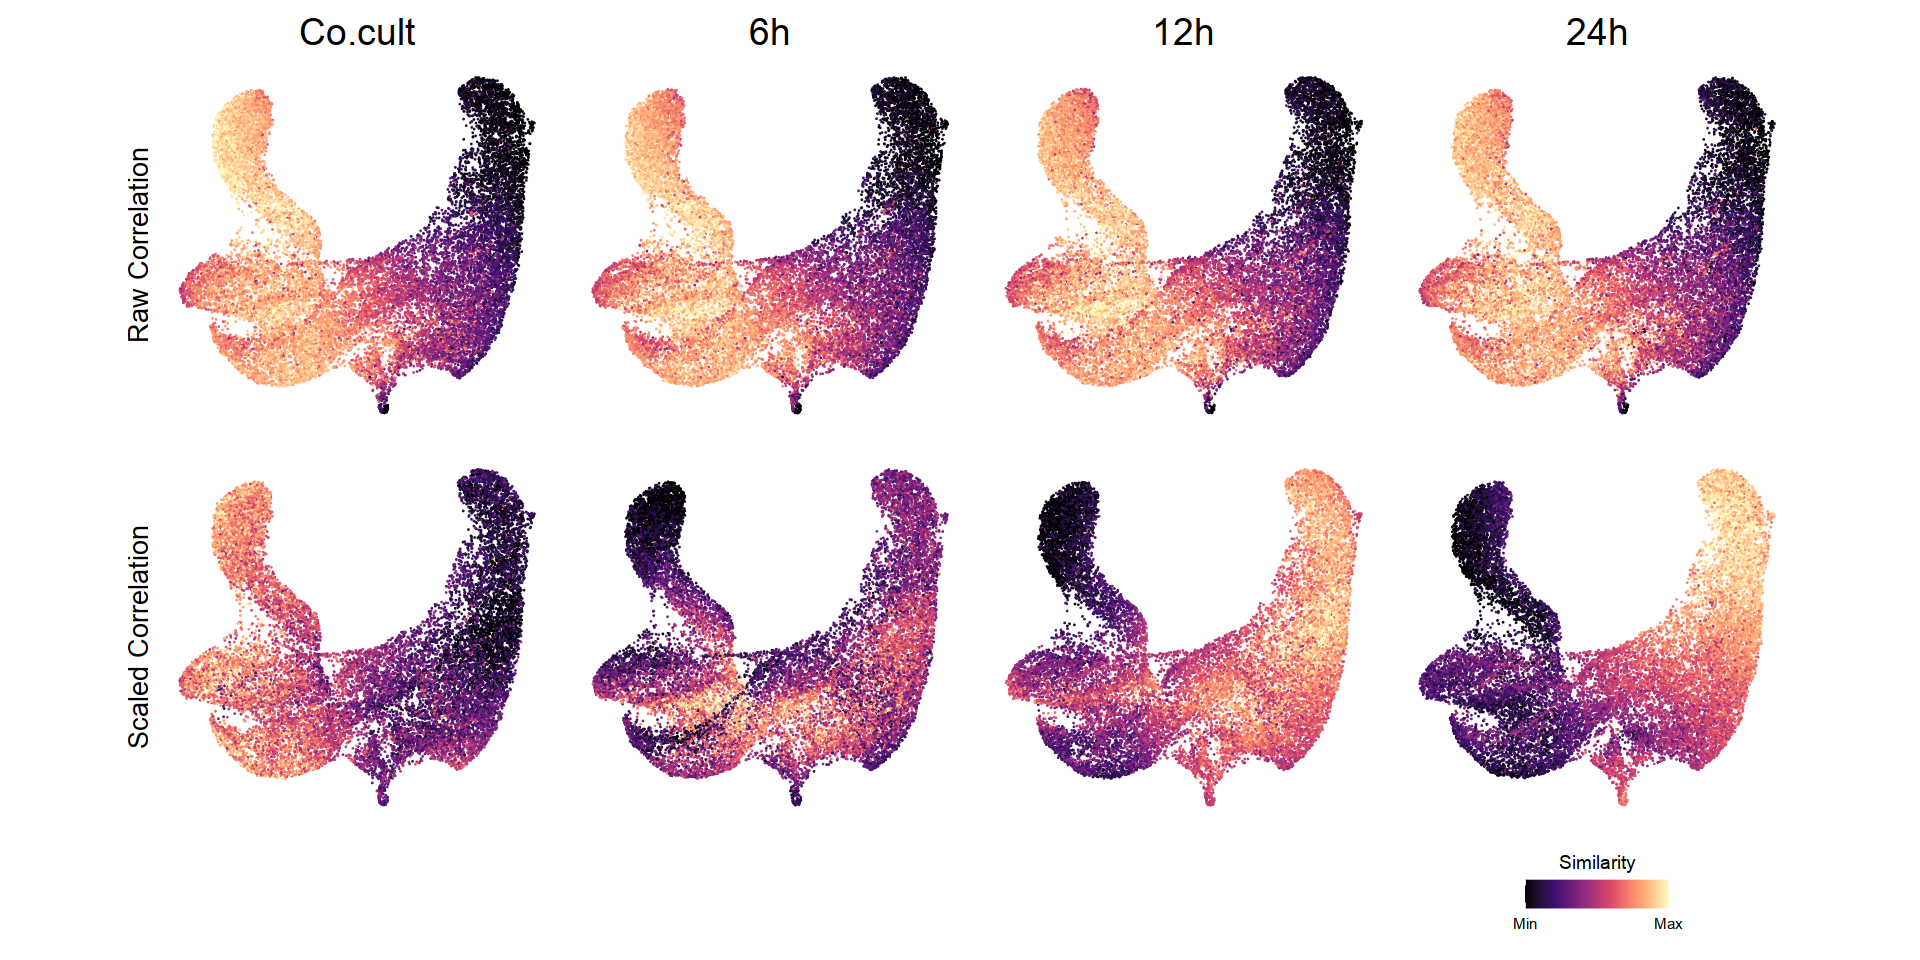

In [713]:
options(repr.plot.width = 16, repr.plot.height = 8)

combined_sims <- wrap_plots(c(raw_sim_plots[select_times],
           scaled_sim_plots[select_times]), 
           nrow=2)

combined_sims

In [714]:
saveRDS(combined_sims, file=sprintf("./subfigs/%s_rna_sim.rds",
                                    format(Sys.Date(), "%Y%m%d")))

---

In [675]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.26.0               SummarizedExperiment_1.16.1
 [3] DelayedArray_0.12.3         BiocParallel_1.20.1        
 [5] Biobase_2.46.0              GenomicRanges_1.38.0       
 [7] GenomeInfoDb_1.22.1         IRanges_2.20.2             
 [9] S4Vectors_0.24.4          